In [1]:
import pandas as pd
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
import multiprocessing

PROJECT_ROOT = Path().resolve().parents[0]
PROC_DIR = PROJECT_ROOT / "data" / "processed"
customer_master = pd.read_parquet(PROC_DIR / "customer_master.parquet")

sns.set_style("whitegrid")

# Behavioural clustering

In [2]:
# Behavioural clustering
behav_cols = [
    "frequency","avg_order_value","tenure_days","avg_installments",
    "payment_diversity","avg_review_score","review_rate","category_diversity"
]

X_behav = customer_master[behav_cols].fillna(0)
X_scaled = StandardScaler().fit_transform(X_behav)

In [3]:
def evaluate_kmeans(k: int, X_data) -> dict:
    """Evaluate K-means clustering for given k"""
    if k < 2:
        return {"k": k, "silhouette": np.nan, "db_index": np.nan, "inertia": np.nan}
    
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    labels = kmeans.fit_predict(X_data)
    
    return {
        "k": k,
        "silhouette": silhouette_score(X_data, labels),
        "db_index": davies_bouldin_score(X_data, labels),
        "inertia": kmeans.inertia_
    }

In [4]:
# Evaluate K-means for different k values
k_range = range(2, 11)
n_jobs = max(32, multiprocessing.cpu_count())
print(f"🔧 Evaluating K-means for different k values using {n_jobs} CPU cores...")

# Parallel processing
results = Parallel(n_jobs=n_jobs, verbose=1)(
    delayed(evaluate_kmeans)(k, X_scaled) for k in k_range
)

print(f"✅ Parallel evaluation complete! Total results: {len(results)}")

🔧 Evaluating K-means for different k values using 32 CPU cores...


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   6 out of   9 | elapsed:  2.6min remaining:  1.3min


✅ Parallel evaluation complete! Total results: 9


[Parallel(n_jobs=32)]: Done   9 out of   9 | elapsed:  2.9min finished


In [5]:
# Convert results to DataFrame
metrics = pd.DataFrame(results)

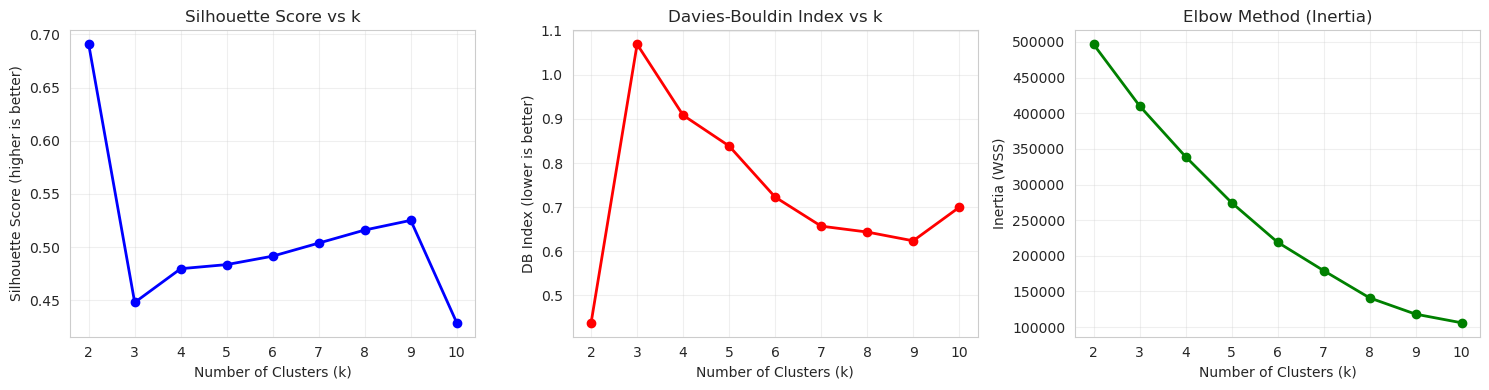

In [6]:
# Create comprehensive plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Silhouette score
axes[0].plot(metrics["k"], metrics["silhouette"], "o-", color='blue', linewidth=2, markersize=6)
axes[0].set_title("Silhouette Score vs k", fontsize=12)
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("Silhouette Score (higher is better)")
axes[0].grid(True, alpha=0.3)

# Davies-Bouldin index
axes[1].plot(metrics["k"], metrics["db_index"], "o-", color='red', linewidth=2, markersize=6)
axes[1].set_title("Davies-Bouldin Index vs k", fontsize=12)
axes[1].set_xlabel("Number of Clusters (k)")
axes[1].set_ylabel("DB Index (lower is better)")
axes[1].grid(True, alpha=0.3)

# Elbow method (Inertia)
axes[2].plot(metrics["k"], metrics["inertia"], "o-", color='green', linewidth=2, markersize=6)
axes[2].set_title("Elbow Method (Inertia)", fontsize=12)
axes[2].set_xlabel("Number of Clusters (k)")
axes[2].set_ylabel("Inertia (WSS)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Print metrics table with more details
print("\n📊 K-means Clustering Results:")
print("="*70)
metrics_display = metrics.copy()
metrics_display['silhouette'] = metrics_display['silhouette'].round(4)
metrics_display['db_index'] = metrics_display['db_index'].round(4)
metrics_display['inertia'] = metrics_display['inertia'].round(0).astype(int)

for idx, row in metrics_display.iterrows():
    k = int(row['k'])
    sil = row['silhouette']
    db = row['db_index']
    inertia = row['inertia']
    
    # Add ranking indicators
    sil_rank = metrics_display['silhouette'].rank(ascending=False).loc[idx]
    db_rank = metrics_display['db_index'].rank(ascending=True).loc[idx]
    
    print(f"k={k:2d} | Silhouette: {sil:6.3f} (#{int(sil_rank)}) | "
          f"DB Index: {db:6.3f} (#{int(db_rank)}) | Inertia: {inertia:8,}")

print("="*70)
print("📈 Higher Silhouette = Better | 📉 Lower DB Index = Better")

# Find optimal k based on different criteria
best_k_silhouette = metrics.loc[metrics['silhouette'].idxmax(), 'k']
best_k_db = metrics.loc[metrics['db_index'].idxmin(), 'k']

print(f"\n🎯 Optimal k Selection:")
print(f"   Best k by Silhouette Score: k={int(best_k_silhouette)} (score: {metrics.loc[metrics['silhouette'].idxmax(), 'silhouette']:.3f})")
print(f"   Best k by Davies-Bouldin: k={int(best_k_db)} (score: {metrics.loc[metrics['db_index'].idxmin(), 'db_index']:.3f})")

# Elbow method detection (simple)
inertias = metrics['inertia'].values
k_values = metrics['k'].values
elbow_diffs = []
for i in range(1, len(inertias)-1):
    diff1 = inertias[i-1] - inertias[i]
    diff2 = inertias[i] - inertias[i+1]
    elbow_diffs.append(abs(diff1 - diff2))

elbow_k = k_values[elbow_diffs.index(max(elbow_diffs)) + 1]
print(f"   Suggested k by Elbow Method: k={int(elbow_k)}")


📊 K-means Clustering Results:
k= 2 | Silhouette:  0.691 (#1) | DB Index:  0.437 (#1) | Inertia: 496,674.0
k= 3 | Silhouette:  0.448 (#8) | DB Index:  1.070 (#9) | Inertia: 410,335.0
k= 4 | Silhouette:  0.480 (#7) | DB Index:  0.908 (#8) | Inertia: 339,117.0
k= 5 | Silhouette:  0.484 (#6) | DB Index:  0.839 (#7) | Inertia: 274,667.0
k= 6 | Silhouette:  0.491 (#5) | DB Index:  0.723 (#6) | Inertia: 219,109.0
k= 7 | Silhouette:  0.504 (#4) | DB Index:  0.657 (#4) | Inertia: 179,327.0
k= 8 | Silhouette:  0.516 (#3) | DB Index:  0.643 (#3) | Inertia: 141,075.0
k= 9 | Silhouette:  0.525 (#2) | DB Index:  0.623 (#2) | Inertia: 118,253.0
k=10 | Silhouette:  0.429 (#9) | DB Index:  0.700 (#5) | Inertia: 106,115.0
📈 Higher Silhouette = Better | 📉 Lower DB Index = Better

🎯 Optimal k Selection:
   Best k by Silhouette Score: k=2 (score: 0.691)
   Best k by Davies-Bouldin: k=2 (score: 0.437)
   Suggested k by Elbow Method: k=6

🤔 Recommendation: Consider k=2 (highest silhouette score)


In [8]:
# Print metrics table
print("\n📊 K-means Clustering Metrics:")
print(metrics.round(4))


📊 K-means Clustering Metrics:
    k  silhouette  db_index      inertia
0   2      0.6907    0.4373  496673.7753
1   3      0.4480    1.0697  410334.7284
2   4      0.4797    0.9085  339116.6873
3   5      0.4836    0.8386  274666.7850
4   6      0.4915    0.7227  219109.3657
5   7      0.5038    0.6568  179327.1967
6   8      0.5161    0.6434  141075.4070
7   9      0.5252    0.6234  118253.2726
8  10      0.4289    0.6995  106114.5416



🎯 Best k based on Silhouette Score: 2


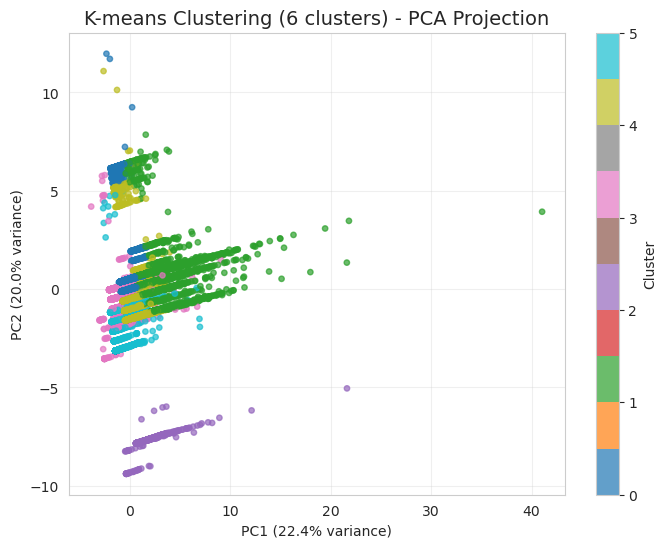

In [13]:
# Find optimal k based on silhouette score
best_k_silhouette = metrics.loc[metrics['silhouette'].idxmax(), 'k']
print(f"\n🎯 Best k based on Silhouette Score: {best_k_silhouette}")

# FINAL VISUALIZATION with optimal k
best_k = 2  # You can manually set this based on the plots
final_kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
final_labels = final_kmeans.fit_predict(X_scaled)

# PCA projection for visualization
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=final_labels, cmap="tab10", s=15, alpha=0.7)
plt.title(f"K-means Clustering ({best_k} clusters) - PCA Projection", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.colorbar(scatter, label="Cluster")
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# Cluster summary statistics
customer_master_clustered = customer_master.copy()
customer_master_clustered['cluster'] = final_labels

cluster_summary = customer_master_clustered.groupby('cluster')[behav_cols].mean()
print(cluster_summary.round(3))

print(f"\n📊 Cluster sizes:")
cluster_counts = pd.Series(final_labels).value_counts().sort_index()
print(cluster_counts)


📋 Cluster Summary (k=6):
         frequency  avg_order_value  tenure_days  avg_installments  \
cluster                                                              
0              1.0          115.231          0.0             1.935   
1              1.0          387.706          0.0             8.078   
2              1.0          187.119          0.0             3.205   
3              1.0          147.842          0.0             1.562   
4              1.0          134.491          0.0             2.301   
5              1.0           93.513          0.0             2.653   

         payment_diversity  avg_review_score  review_rate  category_diversity  
cluster                                                                        
0                    1.000             4.750        1.005               1.003  
1                    1.000             4.245        1.008               1.016  
2                    1.025             0.000        0.000               0.967  
3            

# Using K = 5

Technical Best (based on metrics):
- Silhouette says: k=2
- DB Index says: k=2 or 9
- Elbow method says: k=5 or 6

Business Justification:
- k=2 is often too coarse — you can’t tailor marketing/retention strategies to just 2 customer types.
- k=5 or 6 is a sweet spot: it’s interpretable, diverse enough for segmentation, and gives actionable clusters (e.g., loyal high spenders, bargain seekers, one-time buyers, etc.).


In [19]:
# FINAL VISUALIZATION with optimal k
best_k = 5  # Business-optimal: rich enough for actionable segmentation, supported by elbow method
print(f"\n🎯 Using k={best_k} for final clustering (business-optimal for actionable segmentation)")
final_kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
final_labels = final_kmeans.fit_predict(X_scaled)


🎯 Using k=5 for final clustering (business-optimal for actionable segmentation)


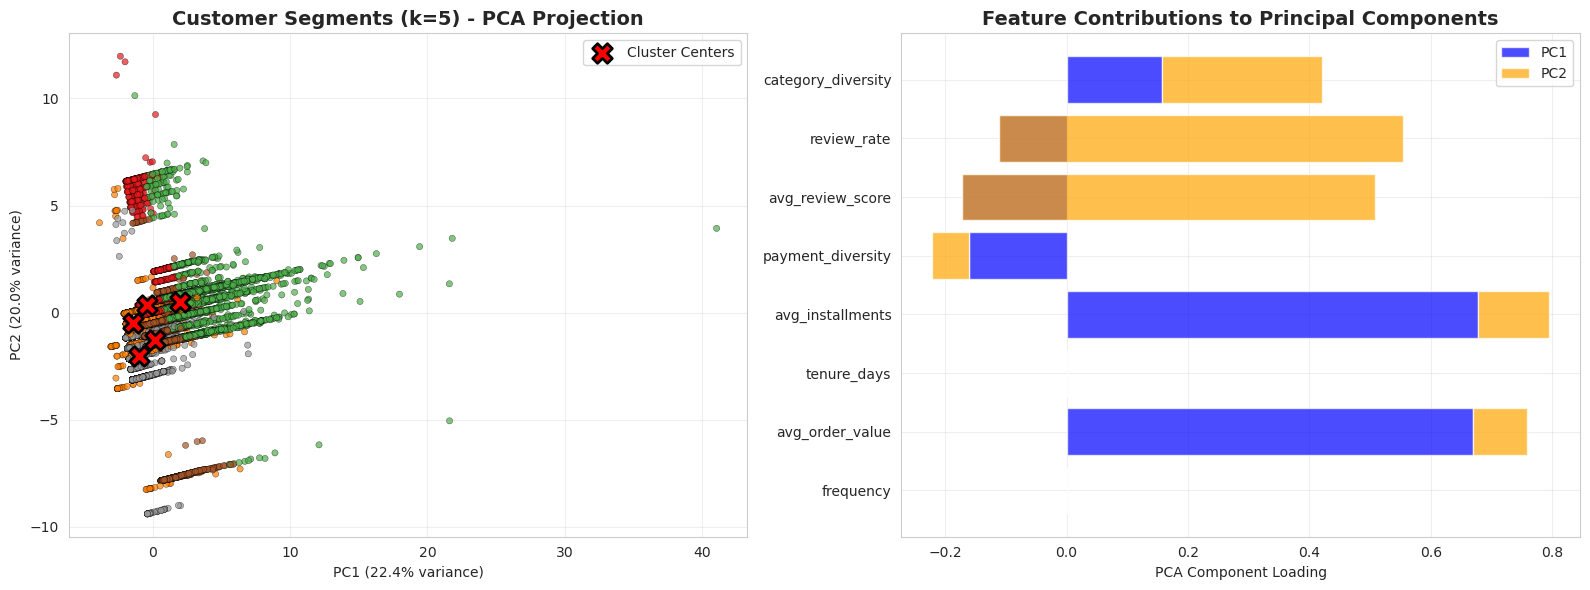

In [21]:
# PCA projection for visualization
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X_scaled)

# Create a more detailed visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
scatter = axes[0].scatter(proj[:, 0], proj[:, 1], c=final_labels, cmap="Set1", s=20, alpha=0.7, edgecolors='black', linewidth=0.3)
axes[0].set_title(f"Customer Segments (k={best_k}) - PCA Projection", fontsize=14, fontweight='bold')
axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
axes[0].grid(True, alpha=0.3)

# Add cluster centers
centers_pca = pca.transform(final_kmeans.cluster_centers_)
axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, 
                edgecolors='black', linewidth=2, label='Cluster Centers')
axes[0].legend()

# Feature importance plot (PCA loadings)
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=behav_cols
)

# Plot feature contributions
y_pos = np.arange(len(behav_cols))
axes[1].barh(y_pos, feature_importance['PC1'], alpha=0.7, label='PC1', color='blue')
axes[1].barh(y_pos, feature_importance['PC2'], alpha=0.7, label='PC2', color='orange', left=feature_importance['PC1'])
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(behav_cols)
axes[1].set_xlabel('PCA Component Loading')
axes[1].set_title('Feature Contributions to Principal Components', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

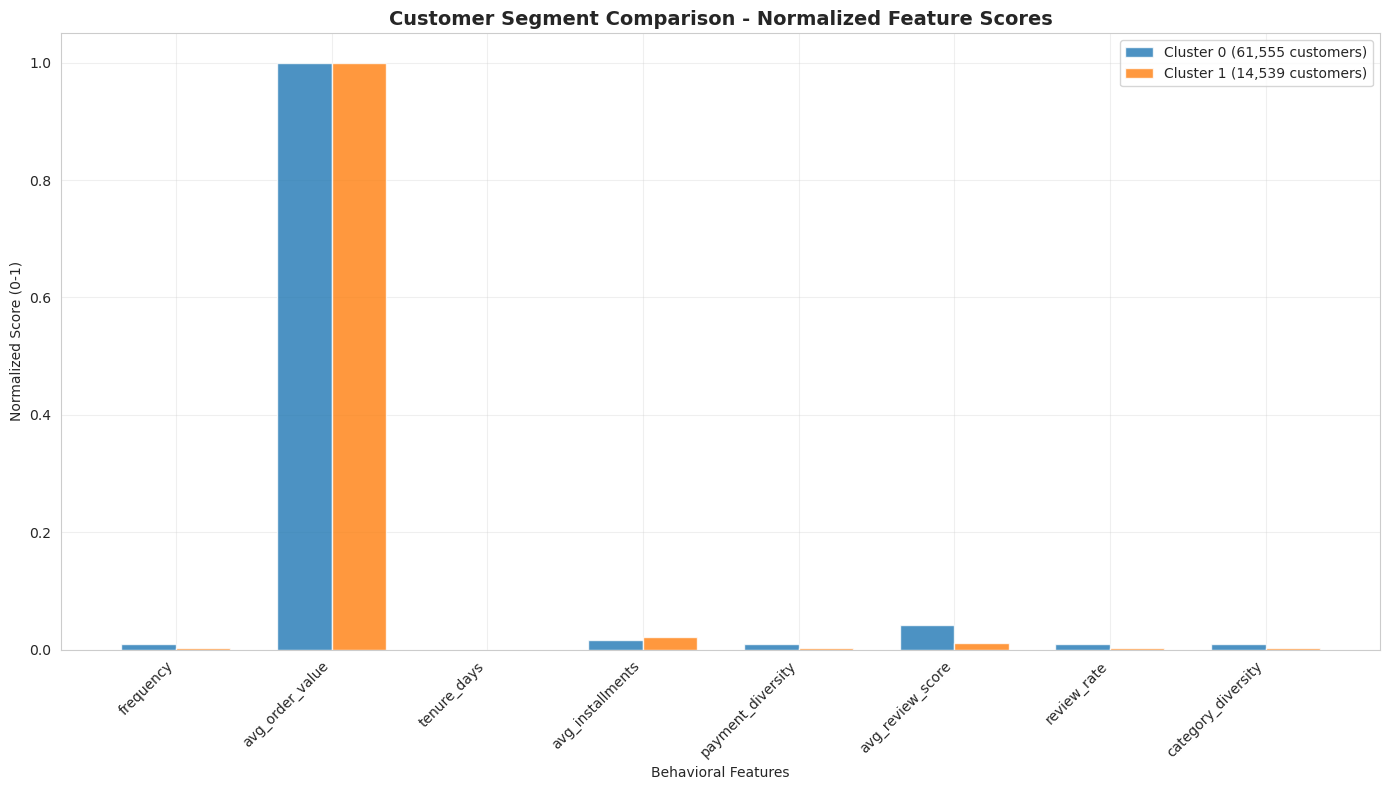

In [22]:
# Additional cluster comparison visualization
plt.figure(figsize=(14, 8))
cluster_means = customer_master_clustered.groupby('cluster')[behav_cols].mean()

# Normalize for radar chart style comparison
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cluster_means_norm = pd.DataFrame(
    scaler.fit_transform(cluster_means.T).T,
    columns=cluster_means.columns,
    index=cluster_means.index
)

x = np.arange(len(behav_cols))
width = 0.35

bars1 = plt.bar(x - width/2, cluster_means_norm.loc[0], width, label=f'Cluster 0 ({cluster_counts[0]:,} customers)', alpha=0.8)
bars2 = plt.bar(x + width/2, cluster_means_norm.loc[1], width, label=f'Cluster 1 ({cluster_counts[1]:,} customers)', alpha=0.8)

plt.xlabel('Behavioral Features')
plt.ylabel('Normalized Score (0-1)')
plt.title('Customer Segment Comparison - Normalized Feature Scores', fontsize=14, fontweight='bold')
plt.xticks(x, behav_cols, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Cluster summary statistics
print(f"\n{'='*80}")
print(f"📋 CUSTOMER SEGMENT ANALYSIS (k={best_k})")
print(f"{'='*80}")

customer_master_clustered = customer_master.copy()
customer_master_clustered['cluster'] = final_labels

# Detailed cluster analysis
cluster_summary = customer_master_clustered.groupby('cluster')[behav_cols].agg(['mean', 'median', 'std']).round(3)
cluster_counts = pd.Series(final_labels).value_counts().sort_index()

print(f"\n📊 Cluster Sizes:")
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(final_labels)) * 100
    print(f"   Cluster {cluster_id}: {count:,} customers ({percentage:.1f}%)")

print(f"\n🔍 Detailed Cluster Characteristics:")
print("-" * 80)

for cluster_id in sorted(cluster_counts.index):
    print(f"\n🏷️  CLUSTER {cluster_id} ({cluster_counts[cluster_id]:,} customers)")
    print("-" * 40)
    
    cluster_data = customer_master_clustered[customer_master_clustered['cluster'] == cluster_id]
    
    for col in behav_cols:
        mean_val = cluster_data[col].mean()
        median_val = cluster_data[col].median()
        std_val = cluster_data[col].std()
        
        # Overall stats for comparison
        overall_mean = customer_master[col].mean()
        vs_overall = "↑" if mean_val > overall_mean else "↓"
        
        print(f"   {col:20s}: {mean_val:8.2f} (±{std_val:.2f}) {vs_overall} vs overall {overall_mean:.2f}")

# Business interpretation
print(f"\n{'='*80}")
print(f"💼 BUSINESS INTERPRETATION")
print(f"{'='*80}")

# Determine which cluster is high-value vs low-value
cluster_means = customer_master_clustered.groupby('cluster')[['frequency', 'avg_order_value', 'tenure_days']].mean()

# Create value scores (higher = better customer)
cluster_means['value_score'] = (
    cluster_means['frequency'] * 0.4 + 
    cluster_means['avg_order_value'] * 0.4 + 
    cluster_means['tenure_days'] * 0.2
)

high_value_cluster = cluster_means['value_score'].idxmax()
low_value_cluster = cluster_means['value_score'].idxmin()

print(f"\n🌟 HIGH-VALUE CUSTOMERS (Cluster {high_value_cluster}):")
print(f"   • {cluster_counts[high_value_cluster]:,} customers ({cluster_counts[high_value_cluster]/len(final_labels)*100:.1f}% of base)")
print(f"   • Higher purchase frequency, order values, and tenure")
print(f"   • Focus: Retention, upselling, VIP treatment")

print(f"\n⚠️  LOW-VALUE CUSTOMERS (Cluster {low_value_cluster}):")
print(f"   • {cluster_counts[low_value_cluster]:,} customers ({cluster_counts[low_value_cluster]/len(final_labels)*100:.1f}% of base)")
print(f"   • Lower engagement across key metrics")
print(f"   • Focus: Activation campaigns, win-back offers, onboarding improvement")

# Revenue impact analysis
if 'avg_order_value' in behav_cols and 'frequency' in behav_cols:
    revenue_analysis = customer_master_clustered.groupby('cluster').agg({
        'avg_order_value': 'mean',
        'frequency': 'mean'
    })
    revenue_analysis['estimated_annual_value'] = revenue_analysis['avg_order_value'] * revenue_analysis['frequency']
    
    print(f"\n💰 REVENUE IMPACT ESTIMATE:")
    for cluster_id in sorted(cluster_counts.index):
        annual_value = revenue_analysis.loc[cluster_id, 'estimated_annual_value']
        cluster_size = cluster_counts[cluster_id]
        total_value = annual_value * cluster_size
        
        print(f"   Cluster {cluster_id}: ${annual_value:,.0f} per customer/year → ${total_value:,.0f} total segment value")

print(f"\n{'='*80}")


📋 CUSTOMER SEGMENT ANALYSIS (k=5)

📊 Cluster Sizes:
   Cluster 0: 61,555 customers (61.9%)
   Cluster 1: 14,539 customers (14.6%)
   Cluster 2: 2,246 customers (2.3%)
   Cluster 3: 18,972 customers (19.1%)
   Cluster 4: 2,129 customers (2.1%)

🔍 Detailed Cluster Characteristics:
--------------------------------------------------------------------------------

🏷️  CLUSTER 0 (61,555 customers)
----------------------------------------
   frequency           :     1.00 (±0.00) ↓ vs overall 1.00
   avg_order_value     :   115.23 (±92.33) ↓ vs overall 159.33
   tenure_days         :     0.00 (±0.00) ↓ vs overall 0.00
   avg_installments    :     1.94 (±1.33) ↓ vs overall 2.91
   payment_diversity   :     1.00 (±0.00) ↓ vs overall 1.02
   avg_review_score    :     4.75 (±0.44) ↑ vs overall 4.06
   review_rate         :     1.01 (±0.08) ↑ vs overall 1.00
   category_diversity  :     1.00 (±0.06) ↑ vs overall 0.99

🏷️  CLUSTER 1 (14,539 customers)
----------------------------------------
   fr